In [6]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import cv2
import os   
import glob
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from keras.models import Model,Sequential
from keras.layers import Dense, Flatten,Conv2D,MaxPooling2D
from keras.layers.normalization import BatchNormalization
import seaborn as sns
from keras.applications.vgg16 import VGG16

 

In [7]:
# !pip install xgboost
# from google.colab import drive
# drive.mount('/content/drive') 

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

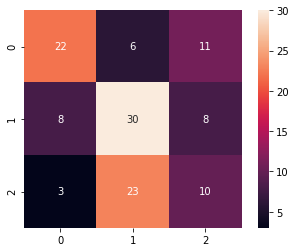

In [8]:
# XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
#               colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
#               importance_type='gain', interaction_constraints='',
#               learning_rate=0.300000012, max_delta_step=0, max_depth=6,
#               min_child_weight=1, missing=nan, monotone_constraints='()',
#               n_estimators=100, n_jobs=0, num_parallel_tree=1,
#               objective='multi:softprob', random_state=0, reg_alpha=0,
#               reg_lambda=1, scale_pos_weight=None, subsample=1,
#               tree_method='exact', validate_parameters=1, verbosity=None) 

train_images=[]
train_labels=[]
category=['cll','fl','mcl']
dir="/content/drive/MyDrive/Dataset"

for cat in category:
  path=os.path.join(dir,cat)
  label=category.index(cat)
  for img in os.listdir(path):
    imgpath=os.path.join(path,img)
    dataimg=cv2.imread(imgpath,cv2.IMREAD_COLOR)
    dataimg=cv2.resize(dataimg,(256,256))
    dataimg=cv2.cvtColor(dataimg,cv2.COLOR_RGB2BGR)
    train_images.append(dataimg)
    train_labels.append(label)

train_images=np.array(train_images)
train_labels=np.array(train_labels)

test=['cll','fl','mcl']
test_images=[]
test_labels=[]
testdir="/content/drive/MyDrive/Dataset/testt"

for cat in test:
  path=os.path.join(testdir,cat)
  label=test.index(cat)
  for img in os.listdir(path):
    imgpath=os.path.join(path,img)
    dataimg=cv2.imread(imgpath,cv2.IMREAD_COLOR)
    dataimg=cv2.resize(dataimg,(256,256))
    dataimg=cv2.cvtColor(dataimg,cv2.COLOR_RGB2BGR)
    test_images.append(dataimg)
    test_labels.append(label)

test_images=np.array(test_images)
test_labels=np.array(test_labels)

le=LabelEncoder()
le.fit(test_labels)
test_labels_encoded=le.transform(test_labels)

le.fit(train_labels)
train_labels_encoded=le.transform(train_labels)

x_train,y_train,x_test,y_test=train_images,train_labels_encoded,test_images,test_labels_encoded

#normalise the pixels value to between 0 and 1

x_train,x_test=x_train/255.0,x_test/255.0

#Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights

VGG_model=VGG16(weights='imagenet',include_top=False,input_shape=(256,256,3))

for layer in VGG_model.layers:
  layer.trainable=False

VGG_model.summary()

feature_extractor=VGG_model.predict(x_train)

features=feature_extractor.reshape(feature_extractor.shape[0],-1)

x_for_training=features

model=xgb.XGBClassifier(n_estimators=700,max_depth=5,learning_rate=0.1,n_jobs=-1)
model.fit(x_for_training,y_train)

x_test_feature=VGG_model.predict(x_test)
x_test_features=x_test_feature.reshape(x_test_feature.shape[0],-1)


prediction=model.predict(x_test_features)
prediction=le.inverse_transform(prediction)

print("Accuracy is : ",accuracy_score(test_labels,prediction))
print("confusion matrices is: ",confusion_matrix(test_labels,prediction))

sns.heatmap(confusion_matrix(test_labels,prediction),annot=True)

n=np.random.randint(0,x_test.shape[0])
img=x_test[n]

plt.imshow(img)

input_img=np.expand_dims(img,axis=0)
input_img_feature=VGG_model.predict(input_img)
input_img_features=input_img_feature.reshape(input_img_feature.shape[0],-1)

prediction=model.predict(input_img_features)[0]
prediction=le.inverse_transform([prediction])

print("The prediction is for this image: ",prediction)
print("The actual label for this images is : ",test_labels[n])
print("this is : ",category[test_labels[n]])
